In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import GraphVAE, JointVAE, NonSpatialVAE, SpatialVAE
from torch import optim
from modules.losses import LossKZCP, Loss, Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
from utils import clr_normalize_each_cell
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import umap.umap_ as umap
warnings.filterwarnings('ignore')

In [19]:
dataset = DataBlob()

Injesting Data...: 100%|██████████| 4/4 [00:17<00:00,  4.47s/it]
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not

In [66]:
import cuml

def plot_latent(
    data,
    labels,
    names=None,
    legend=False,
    remove_outliers=False,
    n_components=2,
    separate_dim=False,
    square=False,
    method='umap',
    n_neighbors=None,
    seed=42,
):
    method_names = {'pca': 'PC', 'umap': 'UMAP'}
    axs = []
    for i, (dat, lab) in enumerate(zip(data, labels)):
        ax = plt.gcf().add_subplot(1, len(data), i+1, projection=None)
        axs.append(ax)
        if i == 0 or separate_dim:
            red = cuml.UMAP(
                n_components=n_components,
                n_neighbors=min(200, dat.shape[0] - 1) if n_neighbors is None else n_neighbors,
                min_dist=.5,
                random_state=seed)
            if separate_dim:
                red.fit(dat)
            else:
                red.fit(np.concatenate(data, axis=0))
        plot_data = red.transform(dat)
        if remove_outliers:
            filter = outliers(plot_data)
        for l in np.unique(np.concatenate(labels)):
            data_subset = np.transpose(plot_data[lab == l])
            if remove_outliers:
                data_subset[~filter[lab == l].T] = np.nan
            # ax.scatter(*data_subset, s=3e3*(1/dat.shape[0]), label=l)
            ax.scatter(*data_subset, s=30, label=l, edgecolors='black')
            
        if i == 1 and legend:
            ax.legend()
        if names is not None:
            ax.set_title(names[i])
        ax.set_xlabel(f'{method_names[method]}-1')
        ax.set_ylabel(f'{method_names[method]}-2')
        if n_components == 2 and square:
            ax.set_aspect('equal')
        elif n_components == 3:
            ax.set_zlabel(f'{method_names[method]}-3')
            if square:
                # https://stackoverflow.com/a/13701747
                X, Y, Z = np.transpose(plot_data)
                # Create cubic bounding box to simulate equal aspect ratio
                max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
                Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
                Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
                Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
                for xb, yb, zb in zip(Xb, Yb, Zb):
                    ax.plot([xb], [yb], [zb], 'w')
    if not separate_dim:
        axs_xlim = np.array([ax.get_xlim() for ax in axs])
        axs_ylim = np.array([ax.get_ylim() for ax in axs])
        new_xlim = (axs_xlim.min(axis=0)[0], axs_xlim.max(axis=0)[1])
        new_ylim = (axs_ylim.min(axis=0)[0], axs_ylim.max(axis=0)[1])
        for ax in axs:
            ax.set_xlim(new_xlim)
            ax.set_ylim(new_ylim)

In [21]:
adata = dataset[3] 
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata = adata.uns['protein']
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)

type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

In [ ]:
adata1 = dataset[0]
pdata1 = dataset[0].uns['protein'] 
sc.pp.filter_genes(adata1, min_counts=10)
sc.pp.filter_cells(adata1, min_counts=10)

adata2 = dataset[3]
pdata2 = dataset[3].uns['protein'] 

sc.pp.filter_genes(adata2, min_counts=10)
sc.pp.filter_cells(adata2, min_counts=10)

adata1, pdata1, adata2, pdata2

(AnnData object with n_obs × n_vars = 2037 × 8423
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'protein', 'spatial'
     obsm: 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 2037 × 196
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1302 × 12251
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'protein', 'spatial'
     obsm: 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 1303 × 196
     obsm: 'spatial')

In [ ]:
common_genes = set.intersection(*map(set, [i.var_names for i in [adata1, adata2]]))
common_proteins = set.intersection(*map(set, [i.var_names for i in [pdata1, pdata2]]))

In [ ]:
adata1 = adata1[:, [list(common_genes).index(i) for i in common_genes]]
adata2 = adata2[:, [list(common_genes).index(i) for i in common_genes]]
pdata1 = pdata1[:, [list(common_proteins).index(i) for i in common_proteins]]
pdata2 = pdata2[:, [list(common_proteins).index(i) for i in common_proteins]]

sc.tl.pca(pdata1)
sc.pp.neighbors(pdata1)
sc.tl.leiden(pdata1, resolution=0.3)

sc.tl.pca(pdata2)
sc.pp.neighbors(pdata2)
sc.tl.leiden(pdata2, resolution=0.3)

adata1, pdata1, adata2, pdata2

(View of AnnData object with n_obs × n_vars = 2037 × 8095
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'protein', 'spatial'
     obsm: 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 2037 × 196
     obs: 'leiden'
     uns: 'pca', 'neighbors', 'leiden'
     obsm: 'spatial', 'X_pca'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 1302 × 8095
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'protein', 'spatial'
     obsm: 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 1303 × 196
     obs: 'leiden'
     uns: 'pca', 'neighbors', 'leiden'
     obsm: 'spatial', 'X_pca'
     varm: 'PCs'
     obsp: 'distances', 'connectivities')

In [ ]:
labels1 = [i+'x' for i in pdata1.obs.leiden.values]
labels2 = [i for i in pdata2.obs.leiden.values]

In [ ]:
type1 = labels1 + labels2
type2 = labels1 + labels2

In [68]:
# d11 = np.concatenate([adata1.X.toarray(), adata2.X.toarray()])
# d12 = np.concatenate([pdata1.X.toarray(), pdata2.X.toarray()])

d11 = adata1.X.toarray()
# d11 = adata1.X.toarray()

# adata2.X.toarray()
# d12 = np.concatenate([pdata1.X.toarray(), pdata2.X.toarray()])
d12 = pdata1.X.toarray()

In [69]:
# d11 = d11.data.cpu().numpy()
# d12 = d12.data.cpu().numpy()

In [72]:
gex = featurize(adata, pca_dim=64)
pex = featurize(pdata, pca_dim=64, clr=True)
d11, d12 = gex.features_pca.cpu().numpy(), pex.features_pca.cpu().numpy()
corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
d11 = torch.tensor(d11).float().cuda()
d12 = torch.tensor(d12).float().cuda()
d11.shape, d12.shape

(torch.Size([1303, 64]), torch.Size([1303, 64]))

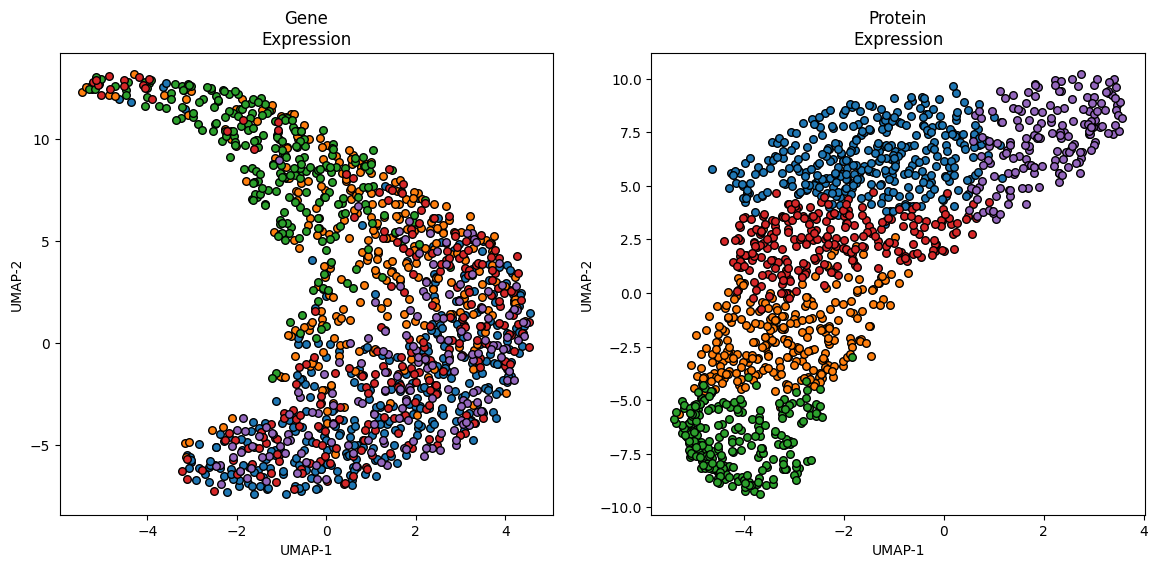

In [73]:
plt.rcParams['figure.figsize'] = (14, 6)
plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True)

In [90]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)
loss_func = Lossv2(alpha=1e-15)

In [ ]:
es = EarlyStopping(patience=200, verbose=False, delta=1e-3, path='gvae.pth')
epochs = 10000
losses = []

embeds = []

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X=[d11, d12], A=gex.adj_norm, corr=corr)
        output.epochs = epochs
        output.gex_features_pca = d11
        output.adj_label = gex.adj_label
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists
        output.corr = gex.adj_label
        
        output.norm = gex.norm
        
        output.pex_features_pca = d12
        loss = loss_func.compute(e, output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        losses.append(float(loss))
        
        es(np.mean(losses), model)   

        # if es.early_stop:
        #     break

        pbar.update()
        pbar.set_description(f'Loss: {np.mean(losses):.3e}| Align: {loss_func.mean_align:.3e} | Cosine: {loss_func.mean_cosine:.3e} \
| Spatial: {loss_func.mean_spatial:.3e} | Adj: {loss_func.mean_adj:.3e}')

Loss: 6.951e+01| Align: 9.601e-10 | Cosine: 6.872e+01 | Spatial: 1.829e-14 | Adj: 7.876e-01:  69%|██████▊   | 6865/10000 [03:20<01:36, 32.60it/s]

In [82]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

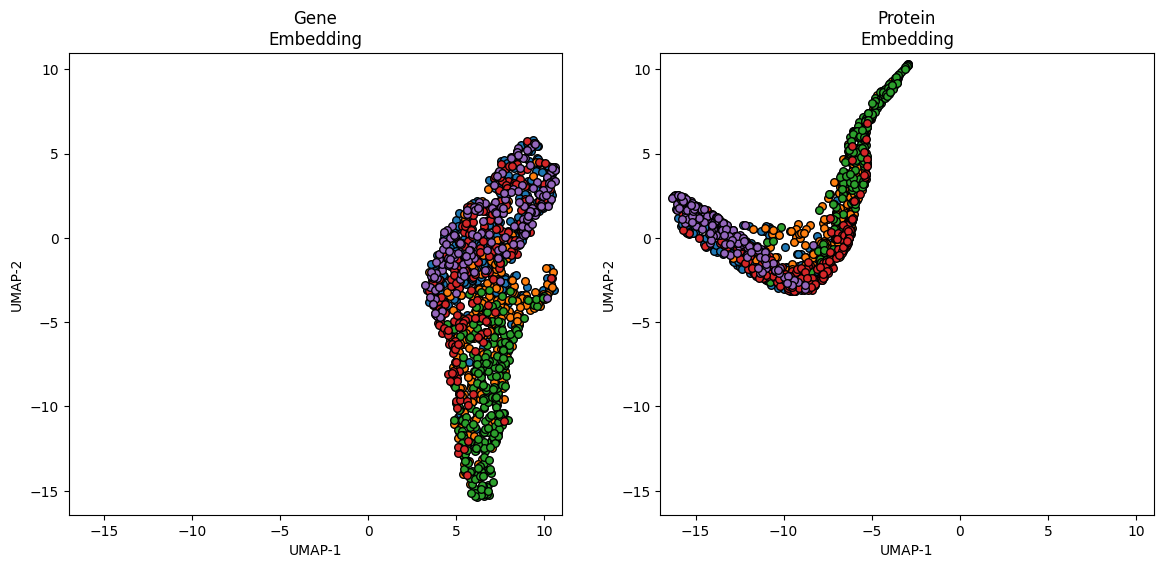

In [83]:
plt.rcParams['figure.figsize'] = (14, 6)
plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False)

In [84]:
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

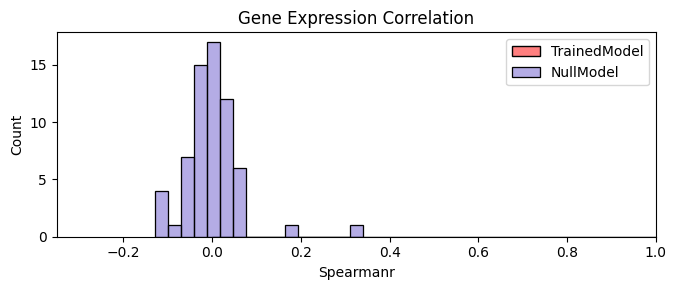

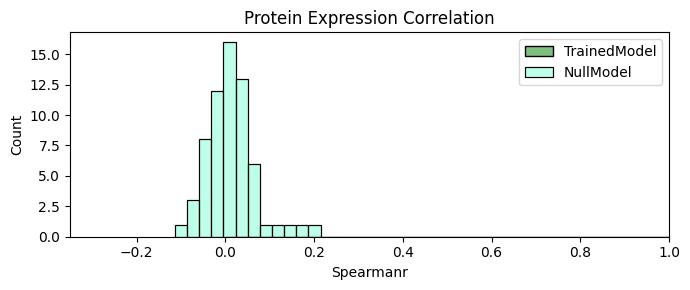

In [85]:
plt.rcParams['figure.figsize'] = (7, 3)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = gex.features_pca.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = pex.features_pca.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = gex.features_pca.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = pex.features_pca.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='slateblue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

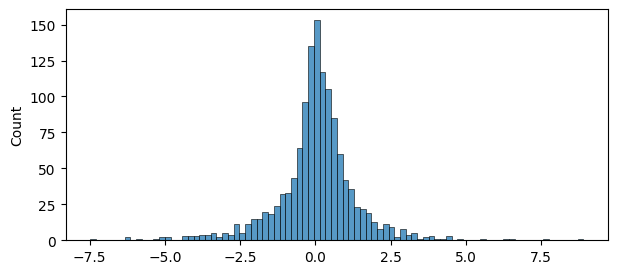

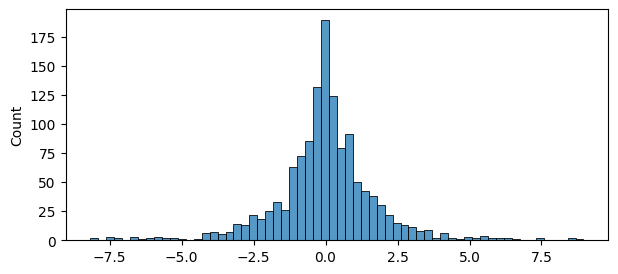

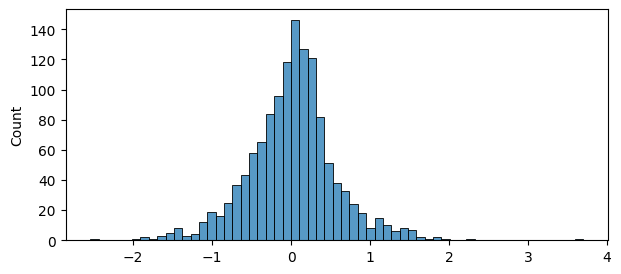

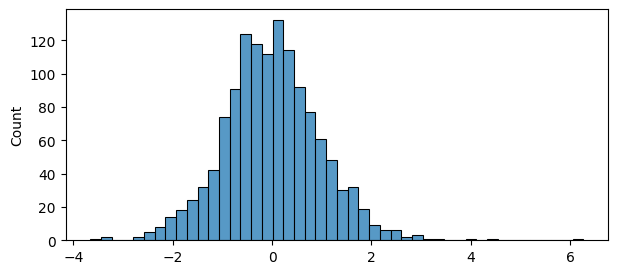

In [219]:
plt.rcParams['figure.figsize'] = (7, 3)
# a = gex.pca.inverse_transform(output.gex_recons.data.cpu().numpy())
# b = gex.features_raw.data.cpu().numpy()
output = integrated_data
ix = 111
a = output.gex_recons.data.cpu().numpy()
b = gex.features_pca.data.cpu().numpy()

c = output.pex_recons.data.cpu().numpy()
d = pex.features_pca.data.cpu().numpy()

sns.histplot(a[:, ix])
plt.show()
sns.histplot(b[:, ix])
plt.show()

sns.histplot(c[:, ix])
plt.show()
sns.histplot(d[:, ix])
plt.show()

In [202]:
# plt.rcParams['figure.figsize'] = (5, 5)
# ix = 99
# sns.scatterplot(b[:, ix], a[:, ix], color='limegreen')
# plt.title(f'Gene: {adata.var_names[ix]}\nCORR: {spearmanr(b[:, ix], a[:, ix]).statistic:.3f}')
# plt.savefig('protein.svg', dpi=120, format='svg')
# plt.show()

In [225]:
modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = gex.features_pca.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = pex.features_pca.data.cpu().numpy()

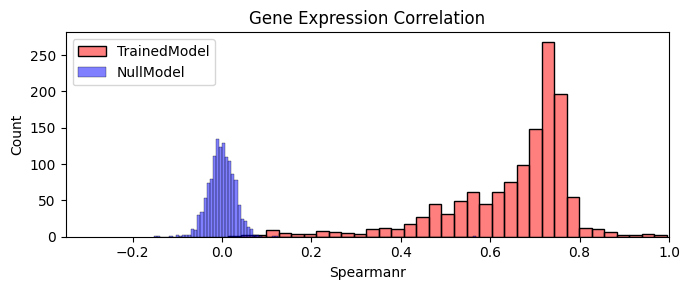

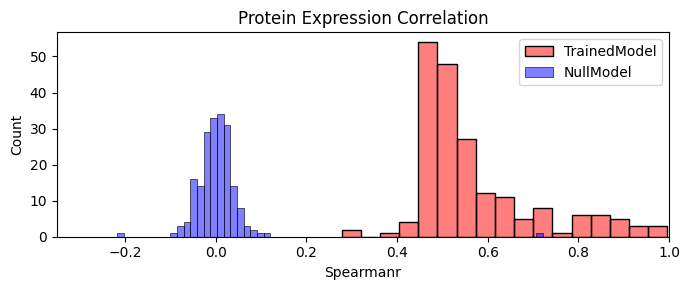

In [238]:
corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_gex.svg', format='svg', dpi=300)
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_pex.svg', format='svg', dpi=300)
plt.show()

In [25]:
model = JointVAE(num_genes=1024, num_proteins=196, 
                 latent_dim=32, gex_encoder_dim=32, 
                 gex_decoder_dim=32, pex_encoder_dim=32, 
                 pex_decoder_dim=32).cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
loss_func = Loss()

In [26]:
epochs = int(1e4)
losses = []
with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train_mode()
        optimizer.zero_grad()
        output = model(gex.features_pca, pex.features_pca, gex.adj_norm)
        output.epochs=100
        output.gex_features_pca = gex.features_pca
        output.pex_features_pca = pex.features_pca
        loss = loss_func.compute(e, output)

        loss.backward()
        optimizer.step()
        
        losses.append(float(loss))
        
        pbar.update()
        pbar.set_description(f'Loss: {np.mean(losses):.3f}')

Loss: 30989528.842:   4%|▎         | 357/10000 [00:05<02:20, 68.82it/s] 


KeyboardInterrupt: 

<AxesSubplot: >

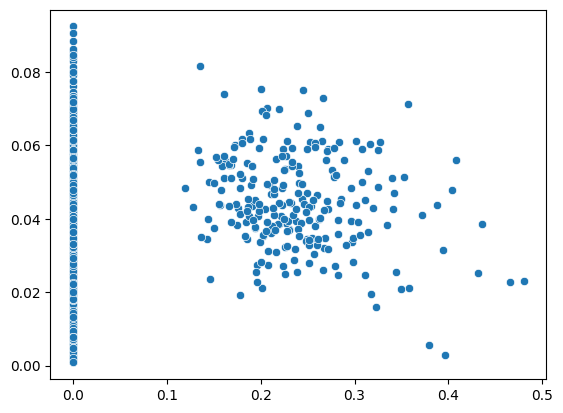

In [70]:
sns.scatterplot(b, a)